In [218]:
import random
import pandas as pd
from datetime import datetime
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer

In [244]:
products = ['iPad', 'iPhone', 'Mac', 'Wearables, Home and Appliances', 'Services']
years = [2021, 2022, 2023]
quartiles = [1,2,3,4]

df = pd.read_excel("Data.xlsx")

In [204]:
# data = []
# for product in products:
#     for year in years:
#         for quartile in quartiles:
#             sales = random.randint(500, 1500)
#             revenue = sales * random.uniform(10, 30)
#             expenses = revenue * random.uniform(0.6, 0.9)
#             data.append(
#                 {
#                     'Product': product,
#                     'Year': year,
#                     'Quartile': quartile,
#                     'Sales': sales,
#                     'Revenue': round(revenue, 2),
#                     'Expenses': round(expenses, 2)
#                 }
#             )
# df = pd.DataFrame(data)

In [245]:
df

,Product,Year,Quartile,Expenses,Revenue,Sales
0,iPad,2021,1,5477.4000,8435,18
1,iPad,2021,2,4988.4078,7807,16
2,iPad,2021,3,4646.1900,7368,16
3,iPad,2021,4,5429.1800,8252,17
4,iPad,2022,1,4469.4800,7248,15
5,iPad,2022,2,4862.7000,7646,16
6,iPad,2022,3,4725.9000,7224,15
7,iPad,2022,4,4691.8800,7174,15
8,iPad,2023,1,5917.1200,9396,20
9,iPad,2023,2,4222.6700,6670,14


In [246]:
# Function to generate individual product summarization
def generate_summarization(row):
    return (f"Sales summary for {row['Product']} in Quartile {row["Quartile"]} of Year {row["Year"]} "
            f"{row['Sales']} units sold, generating a revenue of ${row['Revenue']} and the expenses were ${row['Expenses']}")

# Function to generate comparison summarization for a product over a year
def generate_comparison_summarization(product, year):
    product_data = df[(df['Product'] == product) & (df['Year'] == year)]
    if product_data.empty:
        return None
    best_quartile = product_data.loc[product_data['Sales'].idxmax()]['Quartile']
    worst_quartile = product_data.loc[product_data['Sales'].idxmin()]['Quartile']
    
    return (f"Comparison summary for {product} in {year}: The best-performing quartile was {best_quartile} of Year {year}, "
            f"with {product_data.loc[product_data['Sales'].idxmax()]['Sales']} units sold. "
            f"The worst-performing quartile was {worst_quartile} of Year {year}, "
            f"with only {product_data.loc[product_data['Sales'].idxmin()]['Sales']} units sold.")

# Function to compare two products in a year
def generate_product_comparison(product1, product2, year):
    prod1_data = df[(df['Product'] == product1) & (df['Year'] == year)].set_index('Quartile')
    prod2_data = df[(df['Product'] == product2) & (df['Year'] == year)].set_index('Quartile')
    
    prod1_data, prod2_data = prod1_data.align(prod2_data, join='inner')
    if prod1_data.empty or prod2_data.empty:
        return None
    avg_sales_prod1 = prod1_data['Sales'].mean()
    avg_sales_prod2 = prod2_data['Sales'].mean()
    
    prod1_higher_sales_quartile = sum(prod1_data['Sales'] > prod2_data['Sales'])
    prod2_higher_sales_quartile = sum(prod1_data['Sales'] < prod2_data['Sales'])
    
    return (f"Comparison between {product1} and {product2} in {year}: "
            f"On average, {product1} sold {round(avg_sales_prod1, 2)} units, while {product2} sold {round(avg_sales_prod2, 2)} units. "
            f"{product1} had higher sales in {prod1_higher_sales_quartile} quartiles, while {product2} led in {prod2_higher_sales_quartile} quartiles.")

summaries = []

# Generate individual summarizations and store them with metadata
for _, row in df.iterrows():
    summarization = generate_summarization(row)
    metadata = {
        'Product': row['Product'],
        'Year': row['Year'],
        'Quartile': row['Quartile'],
        'Sales': row['Sales'],
        'Revenue': row['Revenue'],
        'Expenses': row['Expenses'],
        'Type': 'individual'
    }
    summaries.append([summarization, metadata])
    #store_in_pinecone(summarization, metadata)

# Generate comparison summarizations and store them with metadata
for product in products:
    for year in years:
        summarization = generate_comparison_summarization(product, year)
        if not summarization:
            continue
        metadata = {
            'Product': product,
            'Year': year,
            'Type': 'comparison'
        }
        summaries.append([summarization, metadata])
        #store_in_pinecone(summarization, metadata)

# Generate product comparison summarizations and store them with metadata
for i in range(0, len(products)-1, 2):
    for year in years:
        summarization = generate_product_comparison(products[i], products[i+1], year)
        if not summarization:
            continue
        metadata = {
            'Products': [products[i], products[i+1]],
            'Year': year,
            'Type': 'product_comparison'
        }
        summaries.append([summarization, metadata])
        #store_in_pinecone(summarization, metadata)

print("Summarizations have been stored in Pinecone.")

Summarizations have been stored in Pinecone.


In [247]:
for summary in summaries[-40:]:
    print("Summary: ", summary[0], "\n", "Meta Data: ", summary[1], sep="")
    print()

Summary: Sales summary for Wearables, Home and Appliances in Quartile 2 of Year 2022 19 units sold, generating a revenue of $8806 and the expenses were $5683.1
Meta Data: {'Product': 'Wearables, Home and Appliances', 'Year': 2022, 'Quartile': 2, 'Sales': 19, 'Revenue': 8806, 'Expenses': 5683.1, 'Type': 'individual'}

Summary: Sales summary for Wearables, Home and Appliances in Quartile 3 of Year 2022 17 units sold, generating a revenue of $8084 and the expenses were $5324.09
Meta Data: {'Product': 'Wearables, Home and Appliances', 'Year': 2022, 'Quartile': 3, 'Sales': 17, 'Revenue': 8084, 'Expenses': 5324.09, 'Type': 'individual'}

Summary: Sales summary for Wearables, Home and Appliances in Quartile 4 of Year 2022 20 units sold, generating a revenue of $9650 and the expenses were $6290.71
Meta Data: {'Product': 'Wearables, Home and Appliances', 'Year': 2022, 'Quartile': 4, 'Sales': 20, 'Revenue': 9650, 'Expenses': 6290.71, 'Type': 'individual'}

Summary: Sales summary for Wearables, H

In [248]:
pc = Pinecone(api_key="4825304d-82ac-447d-ac9c-f65d46b6a012")

index_name = "atmecs"

index = pc.Index(index_name)

model = SentenceTransformer('all-MiniLM-L6-v2') 

# Function to store summarization and metadata in Pinecone
def store_in_pinecone(summarization, metadata, id):
    vector = model.encode(summarization)
    metadata['summarization'] = summarization
    index.upsert(vectors=[(str(id), vector, metadata)])

In [249]:
count = 0
for summarization, metadata in summaries:
    store_in_pinecone(summarization=summarization, metadata=metadata, id=count)
    count += 1

In [250]:
import matplotlib.pyplot as plt
import pandas as pd
import re

In [251]:
# Updated visualization function with color differentiation and better labeling for stacked bar charts
def plot_sales_data(df, x_col, y_col, title, xlabel, ylabel, color='b', secondary_y_col=None, secondary_y_label=None, stacked=False):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    if stacked:
        # For stacked bar chart, we need to differentiate colors by Quartile
        unique_quartiles = df['Quartile'].unique()
        colors = plt.cm.get_cmap('tab10', len(unique_quartiles))  # Get a colormap with distinct colors
        
        df_grouped = df.pivot_table(index=x_col, columns='Quartile', values=y_col, aggfunc='sum', fill_value=0)
        
        # Plot each quartile with a different color and label
        bottom_stack = None
        for i, quartile in enumerate(unique_quartiles):
            color = colors(i)  # Assign a unique color from colormap
            quartile_label = f'Quartile {quartile}'
            if bottom_stack is None:
                bottom_stack = df_grouped[quartile]
                ax1.bar(df_grouped.index, df_grouped[quartile], label=quartile_label, color=color)
            else:
                ax1.bar(df_grouped.index, df_grouped[quartile], bottom=bottom_stack, label=quartile_label, color=color)
                bottom_stack += df_grouped[quartile]

        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.legend(title="Quartile", loc='upper left')
        
    else:
        # Normal bar chart for the main y-axis
        ax1.bar(df[x_col], df[y_col], color=color, alpha=0.6, label=y_col, width=0.4, align='center')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel, color=color)
        ax1.set_title(title)
        ax1.legend(loc='upper left')

    if secondary_y_col and not df[secondary_y_col].empty:
        ax2 = ax1.twinx()
        ax2.plot(df[x_col], df[secondary_y_col], color='r', marker='o', label=secondary_y_col, linewidth=2)
        ax2.set_ylabel(secondary_y_label, color='r')
        ax2.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Retrieve summaries and visualize based on provided parameters
def retrieve_summaries(product=None, year=None, quartile=None, top_k=50, query=None):
    query_filter = {}
    if product:
        query_filter['Product'] = product
    if year:
        query_filter['Year'] = year
    if quartile:
        query_filter['Quartile'] = quartile

    # Step 1: Filter by metadata if provided
    metadata_filtered_results = None
    if query_filter:
        metadata_filtered_results = index.query(vector=[0]*384, filter=query_filter, top_k=top_k, include_metadata=True)

    # Step 2: Perform similarity search if query string is provided
    similarity_results = None
    if query is not None:
        vector = model.encode(query).tolist()
        if metadata_filtered_results:
            ids = [item['id'] for item in metadata_filtered_results['matches']]
            similarity_results = index.query(vector=vector, top_k=top_k, include_metadata=True, ids=ids)
        else:
            similarity_results = index.query(vector=vector, top_k=top_k, include_metadata=True)

    combined_results = similarity_results if similarity_results else metadata_filtered_results
    
    if combined_results:
        summaries = []
        data = []
        for match in combined_results['matches']:
            summary = match['metadata']['summarization']
            product_name = match['metadata'].get('Product')
            years = match['metadata'].get('Year')
            expenses = match['metadata'].get('Expenses')
            revenue = match['metadata'].get('Revenue')
            sales = match['metadata'].get('Sales')
            quartiles = match['metadata'].get("Quartile")
            summary_type = match['metadata'].get("Type")
            if summary_type == "individual":
                summaries.append((summary, 1))  # Append each textual summary
            else:
                summaries.append((summary, 0))

        
            if product_name and years and expenses and revenue and sales and quartiles:
                # Add the product information into the data dictionary
                data.append({
                    'Product': product_name,  # Include the product name in the data
                    'Quartile': quartiles,
                    'Year': years,
                    'Units Sold': sales,
                    'Expenses': expenses,
                    'Revenue': revenue
                })

        # Create DataFrame for the visualizations
        if not data:
            returning = [summary[0] for summary in summaries if summary[1] == 0] 
            if len(returning) == 0:
                return [summary[0] for summary in summaries]
            return returning
        dfs = pd.DataFrame(data)
        dfs['Quartile'] = pd.to_numeric(dfs['Quartile'])
        dfs.sort_values(by=['Product', 'Year', 'Quartile'], inplace=True)

        # Handle specific cases
        if product and year and quartile:
            # Case 1: Only summarization (print it)
            for summary in summaries:
                print(summary)
        elif product and not year and not quartile:
            # Case 2: Sales visualization across different years and quartiles (Stacked bar)
            plot_sales_data(dfs, 'Year', 'Units Sold', f"Sales of {product} across Quartiles and Years",
                            xlabel='Year', ylabel='Units Sold', stacked=True)
        elif year and not product and not quartile:
            # Case 3: Comparison of sales for different products in the year (Stacked bar)
            plot_sales_data(dfs, 'Product', 'Units Sold', f"Sales Comparison of Products in {year}",
                            xlabel='Product', ylabel='Units Sold', stacked=True)
        elif quartile and not product and not year:
            # Case 4: Sales of different years in the given quartile (Stacked bar)
            plot_sales_data(dfs, 'Year', 'Units Sold', f"Sales in Quartile {quartile} Across Years",
                            xlabel='Year', ylabel='Units Sold', stacked=True)
        elif product and year:
            # Case 5: Current visualization of sales for the product in the given year
            plot_sales_data(dfs, 'Quartile', 'Units Sold', f"Sales of {product} in {year}",
                            xlabel='Quartile', ylabel='Units Sold')
        elif year and quartile:
            # Case 6: Comparison of sales of different products in that quartile of the year
            plot_sales_data(dfs, 'Product', 'Units Sold', f"Sales Comparison in Year {year}, Quartile {quartile}",
                            xlabel='Product', ylabel='Units Sold')
        elif product and quartile:
            # Case 7: Comparison of sales of the product in that quartile across years
            plot_sales_data(dfs, 'Year', 'Units Sold', f"Sales of {product} in Quartile {quartile} Across Years",
                            xlabel='Year', ylabel='Units Sold')
        
        returning = [summary[0] for summary in summaries if summary[1] == 0] 

        if len(returning) == 0:
            return [summary[0] for summary in summaries]
        return returning

In [252]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load a generative model and tokenizer
model_name = "gpt2"  # or any other generative model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_RAG = AutoModelForCausalLM.from_pretrained(model_name)

In [253]:
def parse_question(question):
    # Define basic regex patterns for products, years, and quartiles
    product_pattern = re.compile(r'\b(' + '|'.join(products) + r')\b', re.IGNORECASE)
    year_pattern = re.compile(r'\b(' + '|'.join(map(str, years)) + r')\b')
    quartile_pattern = re.compile(r'\bquartile\s*(1|2|3|4)\b', re.IGNORECASE)

    products_list = product_pattern.findall(question)
    years_list = year_pattern.findall(question)
    quartiles_list = quartile_pattern.findall(question)
    
    return products_list, years_list, quartiles_list


def generate_rag_response(question, summaries):
    context = ". ".join(summaries)  # Combine summaries into one context string
    input_text = f"\nQuestion: {question}\nContext: {context}\nAnswer:"
    
    # Set the eos_token as the pad_token
    tokenizer.pad_token = tokenizer.eos_token

    # Now you can call encode_plus or any other function that requires padding
    inputs = tokenizer.encode_plus(
        input_text,
        return_tensors='pt',
        padding='do_not_pad',  # or 'max_length' if you specify a max_length
        truncation=True
    )

    
    # Generate a response from the model
    with torch.no_grad():
        outputs = model_RAG.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=500,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the generated response
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Optionally, return just the generated answer part
    return extract_unique_answer(answer)


def extract_unique_answer(output):
    lines = output.splitlines()
    for line in lines:
        if line.startswith("Answer:"):
            return line
    return "No answer found."

def rag_application(question):
    products, years, quartiles = parse_question(question)

    if not products:
        return "Could not identify products from the question."
    
    summaries = []
    
    # Step 2: Dynamically call retrievesummaries for each identified product and year
    if len(products) == 2 and len(years) == 1:  # e.g., comparison between two products in the same year
        productA_summaries = retrieve_summaries(product=products[0], year=int(years[0]))
        productB_summaries = retrieve_summaries(product=products[1], year=int(years[0]))
        
        # Store the summaries from both products
        summaries.extend(productA_summaries)
        summaries.extend(productB_summaries)
    
    elif len(products) == 1 and len(years) == 1:  # e.g., a question about a single product in a given year
        product_summaries = retrieve_summaries(product=products[0], year=int(years[0]))
        summaries.extend(product_summaries)
    
    elif len(products) == 1 and len(quartiles) == 1:  # e.g., a question about a product in a specific quartile
        product_summaries = retrieve_summaries(product=products[0], quartile=int(quartiles[0]))
        summaries.extend(product_summaries)
    
    elif len(years) == 1 and len(quartiles) == 1:  # e.g., comparison of products in a specific year and quartile
        quartile_summaries = retrieve_summaries(year=int(years[0]), quartile=int(quartiles[0]))
        summaries.extend(quartile_summaries)


    for product in products:
        summaries.extend(retrieve_summaries(product=product))
    for year in years:
        summaries.extend(retrieve_summaries(year=year))
    for quartile in quartiles:
        summaries.extend(retrieve_summaries(quartile=quartile))
    
    # Step 3: Show visualizations (auto-handled within retrievesummaries)

    # Step 4: Generate a response based on the summaries
    if summaries:
        rag_response = generate_rag_response(question, summaries)
        return rag_response
    else:
        return "No relevant data found."

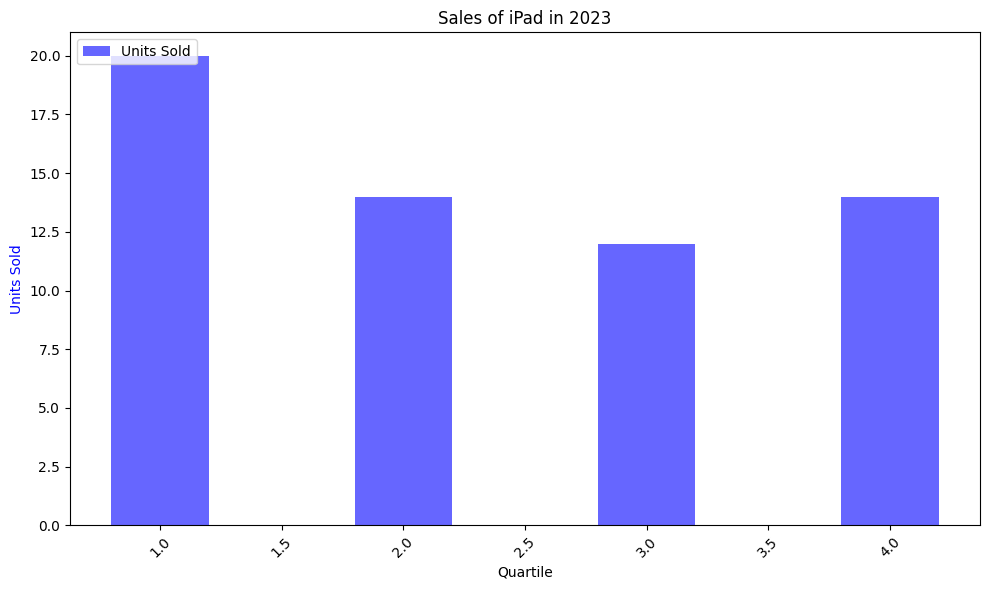

C:\Users\justa\AppData\Local\Temp\ipykernel_20212\3779207451.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_quartiles))  # Get a colormap with distinct colors


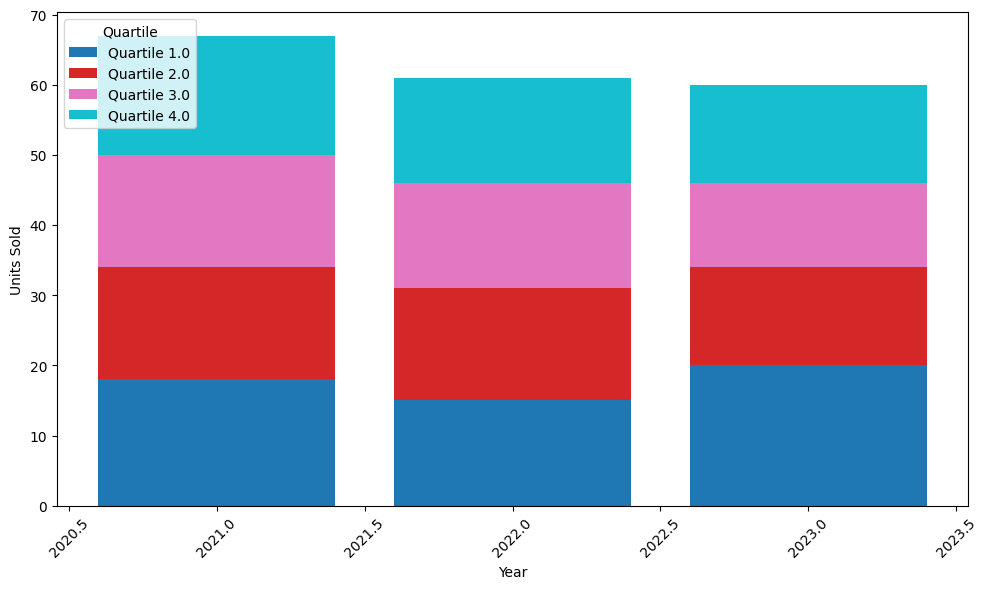

Answer: The best-performing quartile was 1 of Year 2023, with 20 units sold. The worst-performing quartile was 2 of Year 2023, with only 12 units sold.


In [254]:
# Example use case
user_question = "How was iPad in 2023 in quartile 1"
response = rag_application(user_question)
print(response)

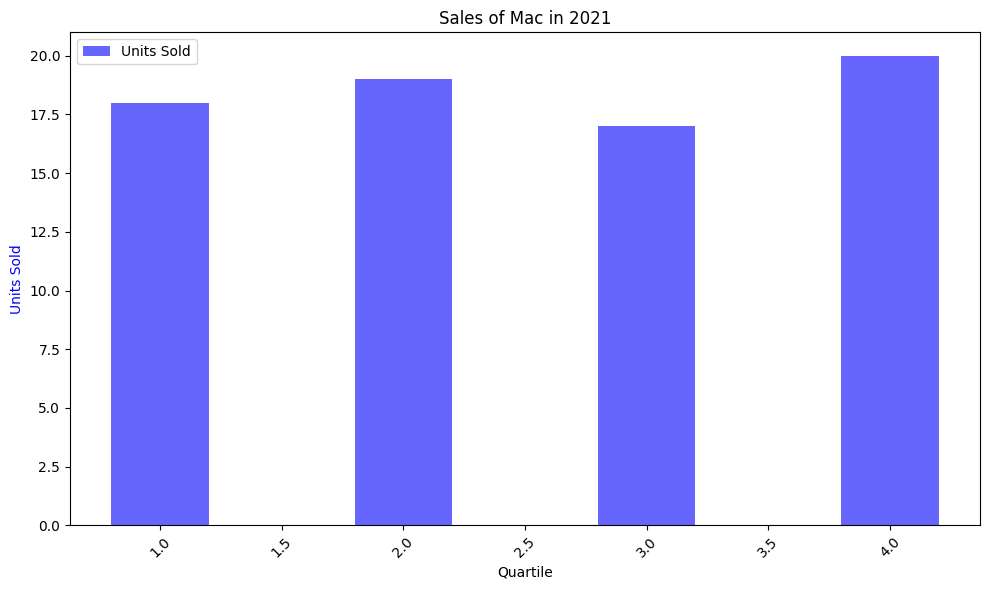

C:\Users\justa\AppData\Local\Temp\ipykernel_20212\3779207451.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_quartiles))  # Get a colormap with distinct colors


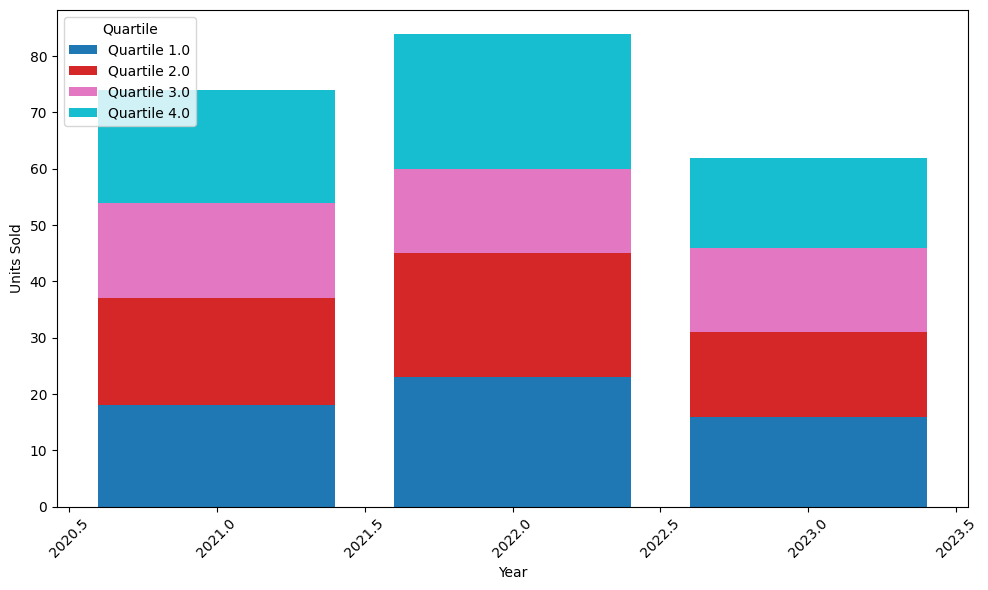

Answer: The best-performing quartile was 1 of Year 2022, with 16 units sold. The worst-performing quartile was 2 of Year 2022, with only 15 units sold.


In [255]:
# Example use case
user_question = "How did Mac Perform in year 2021"
response = rag_application(user_question)
print(response)